# Britter-McQuaid Dense Gas Model

The Britter-McQuaid model is based on the *Workbook on the Dispersion of Dense Gases*, by R.E. Ritter and J. McQuaid, and is a series of correlations relating maximum centerline concentrations to downwind distances that are based upon actual releases.


## Plume Model

Currently the model ony reports the centerline concentration and does not attempt to estimate dispersion in the crosswind or vertical directions, nor does it account for plume-rise.

### Example

Starting with a scenario adapted from example of an LNG release from *Guidelines for Consequence Analysis of Chemical Releases*, CCPS, pg 122, where we are assuming the release to be a liquid jet that essentially immediately vapourizes into a gas at the boiling point, for this we are given:

- Spill rate of liquid - 0.23m³/s
- Spill duration - 174s
- Windspeed at 10m - 10.9m/s
- Liquid density - 425.6kg/m³
- Vapour density at boiling point, -162°C, - 1.76kg/m³

and we wish to calculate the concentration at a downwind distance of 367m.

In [1]:
using Plots
using Interpolations
using GasDispersion

In [2]:
ρₗ = 425.6
ρᵥ = 1.76
u = 10.9
h = 10.0
Tᵣ = 273.15-162

# Mass emission rate
Q = 0.23*ρₗ

# example distance
x₁ = 367

367

The Britter-McQuaid model uses the windspeed at a standard height of 10m. In the scenario given the windspeed is already at 10m so this is does not need to be estimated.

Were that not the case, we could use a power-law distribution estimate the windspeed, *u*, at any height *h*, if we have a known windspeed $u_0$ at a known height $h_0$ using the relationship

$$ {u \over u_0} = \left( h \over h_0 \right)^p $$

Where the parameters *p* are tabulated by stability class. This is what the model does by default.

In [3]:
u₁₀ = u

10.9

The model requires a few more parameters:

The reduced gravity,
$$ g_o = g { {\rho_v - \rho_a } \over \rho_a } $$

and a critical distance $D$ defined as 

$$ D = \sqrt{ V_r \over u_{10} } $$

where $Vr$ is the volumetric release rate
$$ V_r = \frac{Q}{\rho_v} $$ 

In [4]:
# Ambient Conditions
Tₐ = 298 #K
Pₐ = 101325 #Pa
ρₐ = 1.224 #kg/m3

g = 9.80616  # gravity, m/s^2
gₒ = g * ((ρᵥ - ρₐ)/ ρₐ)

Vr = Q/ρᵥ # volumetric release rate of gas
D = √(Vr/u₁₀)

2.258890322239349

Britter and McQuaid suggest that a dense gas model should be used when

$$ \left( g_o V_r \over { u_{10}^3 D} \right)^{1/3} \ge 0.15 $$

In [5]:
( (gₒ * Vr) / (u₁₀^3 * D) )^(1/3) ≥ 0.15

true

So this is an appropriate model to use.

The bulk of the model is a series of correlation curves relating a parameter $\alpha$ to another parameter $\beta$ for a series of concentrations given in volume fraction.
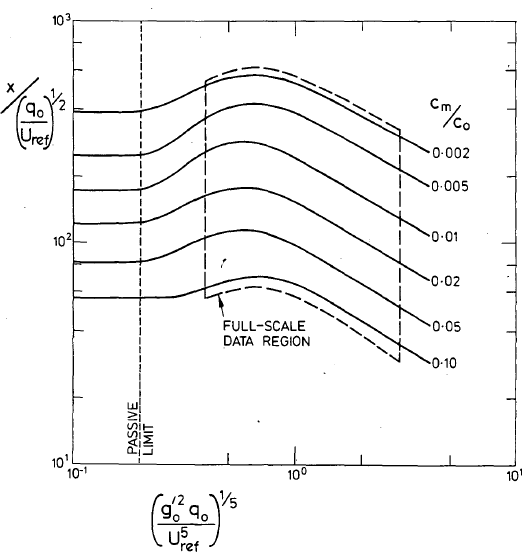

with 
$$ \alpha = 0.2 \cdot \log \left( g_o^2 V_r u_{10}^{-5} \right) $$

and 

$$ \beta = \log \left( x \over D \right) $$

Additionally, for short distances, $ x < 30D $, the following correlation should be used

$$ c = { { 306 \left( \frac{x}{D} \right)^{-2} } \over { 1 + 306 \left( \frac{x}{D} \right)^{-2} } } $$

These curves can be approximated with a series of piece-wise linear functions, which is the approach taken in *Guidelines for Consequence Analysis of Chemical Releases* and the approach I am taking here. Additionally I linearly extrapolate the curves beyond the defined region.

Below I build a series of interpolation functions, one for each concentration, that relates $\alpha$ to $\beta$.

In [6]:
Britter_McQuaid_points = Dict(
    0.010 => ( αs=[-1.0, -0.7, -0.29, -0.2, 1.0],
               βs=[2.25, 2.25, 2.45, 2.45, 1.83]),
    0.005 => ( αs=[-1.0, -0.67, -0.28, -0.15, 1.0],
               βs=[2.4, 2.4, 2.63, 2.63, 2.07]),
    0.020 => ( αs=[-1.0, -0.69, -0.31, -0.16, 1.0],
               βs=[2.08, 2.08, 2.25, 2.25, 1.62]),
    0.002 => ( αs=[-1.0, -0.69, -0.25, -0.13, 1.0],
               βs=[2.6, 2.6, 2.77, 2.77, 2.21]),
    0.100 => ( αs=[-1.0, -0.55, -0.14, 1.0],
               βs=[1.75, 1.75, 1.85, 1.28]),
    0.050 => ( αs=[-1.0, -0.68, -0.29, -0.18, 1.0],
               βs=[1.92, 1.92, 2.06, 2.06, 1.4]),
)

modelcurves = [ ]
concentrations = sort(collect(keys(Britter_McQuaid_points)), rev=true)

for conc in concentrations
    αs, βs = Britter_McQuaid_points[conc]
    f = LinearInterpolation(αs, βs, extrapolation_bc=Line())
    push!(modelcurves, (c=conc, it=f))
end

We can plot these and see that they approximate the curves given in the workbook.

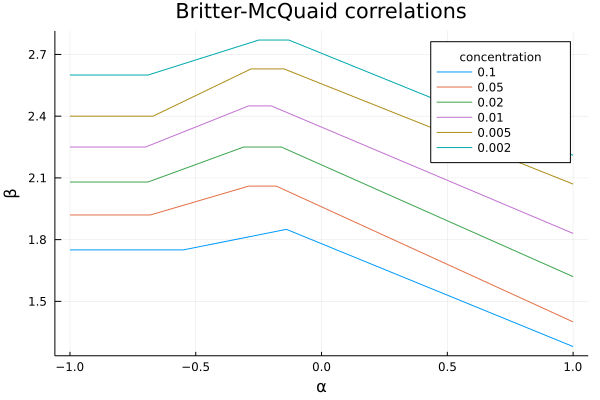

In [7]:
p1 = plot(title="Britter-McQuaid correlations",
      ylabel="β",
      xlabel="α",
      legend=:best,
      legendtitle="concentration",
      legendtitlefontsize=8)

for key in concentrations
    αs, βs = Britter_McQuaid_points[key]
    plot!(p1, αs, βs, lab=key)
end

plot(p1)

The procedure for determining the concentration at a given downwind distance is to first determine the parameter $\alpha$, which is fixed for a given release scenario, then calculate $\beta$ for the desired downwind distance and interpolate between the curves to find the corresponding concentration.

This can be done in julia by calculating the set of points $\left( \beta, c \right)$ that correspond to the points on the curves above at a particular $\alpha$ and using this set to define a new interpolation function, with the added complication that for short distances the other short distance correlation should be used instead.

In [8]:
# the α parameter
α = 0.2*log10( gₒ^2 * Vr * u₁₀^-5 )

# calculates the points for the linear interpolation
cs = [ elem.c for elem in modelcurves ]
βs = [ elem.it(α) for elem in modelcurves ]

# linear interpolation between the short distance correlation
# and the main correlation
βs = [ log10(30); βs]
cs = [ 306*30^-2 / (1+ 306*30^-2); cs ]

# linear interpolation, extrapolates past the end with a straight line
interp = LinearInterpolation(βs, cs, extrapolation_bc=Line())

7-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Float64}, Gridded(Linear())), Line()) with element type Float64:
 0.2537313432835821
 0.1
 0.05
 0.02
 0.01
 0.005
 0.002

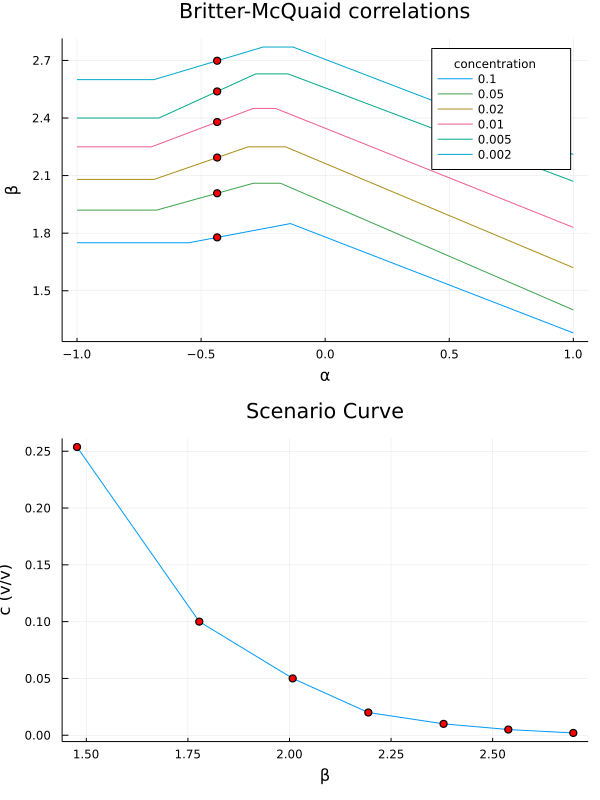

In [9]:
p2 = plot(title="Britter-McQuaid correlations",
      ylabel="β",
      xlabel="α",
      legend=:best,
      legendtitle="concentration",
      legendtitlefontsize=8)

for curve in modelcurves
    c, it = curve.c, curve.it
    as, bs = Britter_McQuaid_points[c]
    plot!(p2, as, bs, lab=c)
    plot!(p2, [α], [it(α)], seriestype=:scatter, lab=false, color=:red)
end

p3 = plot(βs, cs, title="Scenario Curve", seriestype=:line, ylabel="c (v/v)", xlabel="β", lab=false)
plot!(p3, βs, cs, seriestype=:scatter, color=:red, lab=false)


l = @layout [a; b]
plot(p2, p3, layout=l, size=(600,800))

Now that we have this correlation curve, we can use it for the distance of interest.

In [10]:
β = log10(x₁/D)
c′ = interp(β)

0.01909304710372097

The Britter-McQuaid model assumes an isothermal case and the following correction is suggested for non-isothermal cases

$$ c^\prime = { c \over { c + (1-c) \frac{T_a}{T_r} } }$$

Where $c^\prime$ is the concentration from the correlations and $c$ the actual concentration.

re-arranging and taking $T^\prime = \frac{T_a}{T_r} $

$$ c = { { c^\prime T^\prime } \over { 1 - c^\prime + c^\prime T^\prime }}$$

The concentrations in the correlation are in terms of volume fraction, to convert to mass per volume, simply multiply by the density.

$$ c = { { \rho_v c^\prime T^\prime } \over { 1 - c^\prime + c^\prime T^\prime }} $$

In [11]:
T′ = Tₐ/Tᵣ

c₁ = ( ρᵥ*c′*T′)/( 1-c′+c′*T′)

0.0872919843565787

Which we can compare with the result from `GasDispersion.jl`.

In [12]:
ex1 = Scenario( Dict([
    :mass_emission_rate => Q,
    :release_height => h,
    :jet_density => ρᵥ,
    :release_temperature => Tᵣ,
    :windspeed => u,
    :ambient_density => ρₐ,
    :ambient_temperature => Tₐ,
    :pasquill_gifford => "F"
]))

c_bm = plume(ex1, model=:brittermcquaid)

c_bm(x₁, 0, h) ≈ c₁

true

Finally we can compare this answer with that from the reference, where the concentration was found to be 5%(v/v)

In [13]:
cₜₑₓₜ = 0.05*ρᵥ

0.08800000000000001

Which is a difference of <1%, and is likely due to slight differences in how the curves were parametrized and such. Also the original example was working in the opposite direction -- looking for the distance where the concentration was 5%(v/v).